In [2]:
from odc.stac import load
import rasterio
import s3fs

s3_uri = "s3://files.auspatious.com/hsi_example/TD1_004930_20230205_L2A_20230224_03001065_COG.stac-item.json"

# Open S3 object as a file using s3fs
s3 = s3fs.S3FileSystem(anon=True)
with s3.open(s3_uri, "rt") as f:
    stac_dict = json.load(f)
item = pystac.read_dict(stac_dict)

# Select a subset, so it doesn't take a long time
eo_bands_subset = item.assets["reflectance"].extra_fields["eo:bands"][0:1]

# Load the data, telling rasterio to not sign requests
with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    data = load(
        [item],
        measurements=[i["name"] for i in eo_bands_subset]
)

# No need for time
data = data.squeeze("time")

# Stack up the bands, so we have a multi-dimensional raster instead
data_stacked = data.to_array("band")

# Replace the original data object with a nice indexed one
data = data_stacked.assign_coords(band=[float(i["description"]) for i in eo_bands_subset])


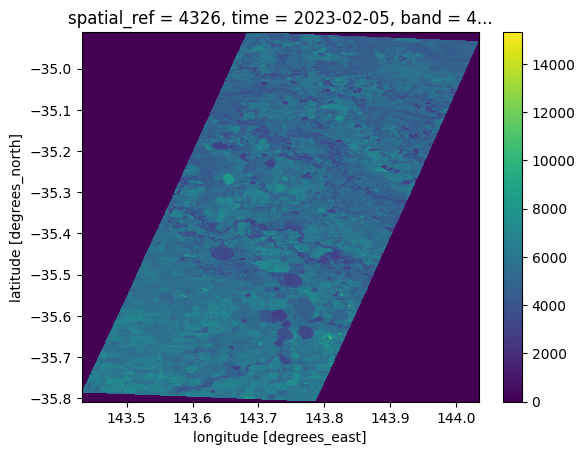

In [3]:
# Now we can select a band by wavelength and plot it!
data.sel(band=450, method="nearest").plot()